# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLVU/HW3'

/content/drive/MyDrive/MLVU/HW3


In [ ]:
"""
Unzip the UCF11 zip file.
- Run this cell only once.
"""
#!unzip -n ./UCF11.zip -d .

'\nUnzip the UCF11 zip file.\n- Run this cell only once.\n'

# Import Modules

In [ ]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from glob import glob
from tqdm import tqdm
from IPython.display import HTML
from sklearn.model_selection import train_test_split

In [ ]:
"""
import more modules you need
"""
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Conv3D, ReLU, BatchNormalization, Dropout, MaxPool3D, Concatenate
from tensorflow.keras.regularizers import l2

In [ ]:
"""
Make sure your runtime type is GPU!
"""
cpus = tf.config.list_physical_devices('CPU')
gpus = tf.config.list_physical_devices('GPU')
print('Num_CPUs:{}, List:{}'.format(len(cpus), cpus))
print('Num_GPUs:{}, List:{}'.format(len(gpus), gpus))

Num_CPUs:1, List:[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Utils

In [ ]:
def bytes_feature(value):
    """
    Returns a bytes_list from a string / byte.

    Do NOT modify this method.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def int64_feature(value):
    """
    Returns a float_list from a float / double.

    Do NOT modify this method.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def float_feature(value):
    """
    Returns a float_list from a float / double.

    Do NOT modify this method.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
    
def plot_frames(videos, labels, grid_width, grid_height, figure_width=15, figure_height=5, y_hats=None):
    """
    Plots videos and labels.

    Do NOT modify this method.
    """
    fig, ax = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figure_width, figure_height)
    video_idx = 0
    imgs = []
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            video = videos[video_idx]
            label = labels[video_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[video_idx])
                if int(labels[video_idx]) != label_idx:
                    title_color = 'r'
            label = InputPipelineBuilder.LABELS[label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            
            for frame_idx, frame in enumerate(video):
                img = ax[i][j].imshow(frame, animated=True, aspect='auto')
                if video_idx==0:
                    imgs.append([img])
                else:
                    imgs[frame_idx].extend([img])
            ani = animation.ArtistAnimation(fig, imgs, interval=150, blit=False)
            video_idx += 1
    plt.close(fig)
    os.makedirs('./temp', exist_ok=True)
    ani.save(f'./temp/frames.gif', writer='pillow', fps=10)
    display(HTML(ani.to_html5_video()))

def plot_history(history):
    """
    Plots training history.
    
    Do NOT modify this method.
    """
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# UCF11

In [ ]:
class InputPipelineBuilder:
    """
    UCF11 Input Pipeline
    - 1. Contains configuration and information about the inputs.
    - 2. Splits the dataset into train/valid/test subets.
    - 3. Load videos and sample frames to use, followed by preprocessing.
    - 4. Store the sampled frames as TFRecord files.
    - 5. Returns TF dataset objects built directly from the TFRecord files.
    """
    # pipeline configurations
    FRAME_SIZE = (56,56)      
    NUM_FRAMES_PER_VIDEO = 16   
    NUM_VIDEOS_PER_RECORD = 64  
    SUBSETS = ['train', 'valid', 'test']
    LABELS = ['basketball', 'biking', 'diving', 'golf_swing',
              'horse_riding', 'soccer_juggling', 'swing', 'tennis_swing',
              'trampoline_jumping', 'volleyball_spiking', 'walking']
    NUM_LABELS = 11
    INPUT_SHAPE = [NUM_FRAMES_PER_VIDEO, *FRAME_SIZE, 3]
    
    def __init__(self, dataset_dir, tfrecord_dir):
        """
        Loads and splits UCF11 to train, validation, and test sets.

        Do NOT modify this method.
        """
        self.dataset_dir = dataset_dir
        self.tfrecord_dir = tfrecord_dir
        self.x = None
        self.y = None
        
    def __str__(self):
        """
        Print the input pipeline configuration and data subsets.
        
        Do NOT modify this method.
        """
        info = ''
        info += f'Labels: {InputPipelineBuilder.LABELS}\n'
        info += f'Dimension to extract per video: {[InputPipelineBuilder.NUM_FRAMES_PER_VIDEO, *InputPipelineBuilder.FRAME_SIZE, 3]}\n'
        info += 'Dataset splitted: '
        if self.x:
            info += '/'.join(InputPipelineBuilder.SUBSETS)
            info += ' [' + '|'.join([str(len(self.x[subset])) for subset in InputPipelineBuilder.SUBSETS]) + ']'
        return info
    
    def split_dataset(self, valid_size=0.2, test_size=0.1, random_state=None):
        """
        Read video lists and split them into subsets
        
        Do NOT modify this method.
        """
        videos = []
        labels = []
        for label_int, label_str in enumerate(InputPipelineBuilder.LABELS):
            path = os.path.join(self.dataset_dir, label_str)
            temp = glob(path+'/**/*.mpg')
            videos.extend(temp)
            labels.extend([label_int,] * len(temp))
        x_train, x_test, y_train, y_test   = train_test_split(videos, labels, test_size=test_size, stratify=labels,
                                                              shuffle=True, random_state=random_state)
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_size, stratify=y_train,
                                                              shuffle=True, random_state=random_state)
        self.x = {'train':x_train, 'valid':x_valid, 'test':x_test}
        self.y = {'train':y_train, 'valid':y_valid, 'test':y_test}            
        
    def convert_dataset_to_tfrecord(self, subset='train'):
        """
        Load and store videos in TFRecord format.
        
        Do NOT modify this method.
        """
        assert subset in InputPipelineBuilder.SUBSETS, 'subset supported: {}'.format(InputPipelineBuilder.SUBSETS)
        videos = self.x[subset]
        labels = self.y[subset]
        tfrecord_dir = os.path.join(self.tfrecord_dir, subset)
        files = glob(tfrecord_dir+'/*')
        for file in files:
            os.remove(file)
        os.makedirs(tfrecord_dir, exist_ok=True)
        for i in tqdm(range(0, len(videos), InputPipelineBuilder.NUM_VIDEOS_PER_RECORD)):            
            tfrecords_file_path = os.path.join(tfrecord_dir, 'tfr_'+str(i))
            with tf.io.TFRecordWriter(tfrecords_file_path) as record_writer:
                upto = min(i+InputPipelineBuilder.NUM_VIDEOS_PER_RECORD, len(videos))
                for video, label in zip(videos[i:upto], labels[i:upto]):
                        example = self.encode_tfrecord(video, label)
                        record_writer.write(example.SerializeToString())
        print("TFRecord Conversion DONE\n")
        
    def convert_tfrecord_to_tfdataset(self, subset='train'):
        """
        Creates a tf.dataset from TFRecord files.

        Do NOT modify this method.
        """
        assert subset in InputPipelineBuilder.SUBSETS, 'subset supported: {}'.format(InputPipelineBuilder.SUBSETS)
        tfrecord_files = glob(os.path.join(self.tfrecord_dir, subset + '/*'))
        dataset = tf.data.TFRecordDataset(tfrecord_files).map(lambda x: self.decode_tfrecord(x))
        return dataset  
        
    def load_video(self, video):
        """
        Loads a video from a given path and samples a certain number of frames at equal distance.
        Preprocsses each frame while sampling.

        Question (a)
        - Use cv2.VideoCapture to access the contents of the video at the given path.
        - Computes the frame indices to sample using ...
        - the number of the total frames achieved with the 'get' method of cv2.VideoCapture.
        - the number of frames to sample is stored as a class variable: InputPipelineBuilder.NUM_FRAMES_PER_VIDEO
        - Read each frame at these indices and apply self.preprocess 
        - Release the capture object at the end.
        - Refer to OpenCV VideoCapture Documentation for further information!

        Inputs
        - video: a file path to a video.
        Returns
        - frames: a numpy array of frames extracted from the video.
        """
        video_obj = cv2.VideoCapture(video)
        total_frames = video_obj.get(cv2.CAP_PROP_FRAME_COUNT)
        idx = np.linspace(0, total_frames - 1, InputPipelineBuilder.NUM_FRAMES_PER_VIDEO, dtype='int')
        frames = []
        for i in idx:
            video_obj.set(cv2.CAP_PROP_POS_FRAMES, i)
            b, img = video_obj.read()
            if not b:
              print("Frame at index {} could not load".format(i))
            frames.append(self.preprocess(img))
        video_obj.release()
        cv2.destroyAllWindows()
        return np.asarray(frames)
    
    def preprocess(self, frame):
        """
        Preprocess the given frame.

        Question (a)
        - Use OpenCV(cv2) methods.
        - 1. Convert the color format from BGR to RGB; OpenCV reads frames in the BGR format.
        - 2. Resize the frame to InputPipelineBuilder.FRAME_SIZE.
        - 3. Normalize.
        
        Inputs
        - frame
        Returns
        - frame: a frame preprocssed.
        """
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_frame = cv2.resize(rgb_frame, InputPipelineBuilder.FRAME_SIZE)
        #NORMALIZE
        resized_frame = resized_frame/255.
        return resized_frame

        
    def encode_tfrecord(self, video, label):
        """
        Convert a set of video and label as tf.train.Example.
        An example contains a byte sequence of one data point and these examples comprise a TFRecord file.

        Question (b)
        - Load frames from a video and use methods in Utils section in order to ...
        - Convert frames to byte_features. You will need to convert np.array frames to a byte array beforehand.
        - Convert label to int64_features.
        - Use these features to initialize tf.train.Features and tf.train.Example
        - Refer to TensorFlow TFRecord Tutorial for further information!

        Inputs
        - video: a video path
        - label: an action label
        Returns
        - example: tf.train.Example
        """
        frames = self.load_video(video)
        frame_features = bytes_feature(frames.tobytes())
        label_feature = int64_feature(label)
        features = tf.train.Features(feature={"frames":frame_features, "label": label_feature})
        example = tf.train.Example(features=features) 
        return example

    def decode_tfrecord(self, tfrecord):
        """
        Decode a tfrecord item.
        You need to specify how many bytes to read from this byte sequence per feature to retrieve a data point.

        Question (b)
        - Use tf.io.FixedLenFeature([], 'type of feature')
        - Use tf.io.parse_single_example, tf.io.decode_raw
        - Use InputPipelineBuilder.INPUT_SHAPE to reshape after decoding frames.
        - Use tf.cast to cast label to tf.int32 after decoding label.
        - Refer to TensorFlow TFRecord Tutorial for further information!

        Inputs
        - tfrecord
        Returns
        - frames
        - labels
        """
        data_feature_description = {
            'frames': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64)
            }
        res = tf.io.parse_single_example(tfrecord, data_feature_description)
        frames = res["frames"]
        label = res["label"]
        frames = tf.io.decode_raw(frames, tf.float64)
        frames = tf.reshape(frames, InputPipelineBuilder.INPUT_SHAPE)
        label =  tf.cast(label, tf.int32)

        
        return frames, label

In [ ]:
"""
Builds a UCF11 input pipeline
"""
input_pipeline_builder = InputPipelineBuilder(dataset_dir='./UCF11', tfrecord_dir='./tfrecord')
input_pipeline_builder.split_dataset(valid_size=0.2, test_size=0.1)
print(input_pipeline_builder)

Labels: ['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding', 'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping', 'volleyball_spiking', 'walking']
Dimension to extract per video: [16, 56, 56, 3]
Dataset splitted: train/valid/test [1149|288|160]


In [ ]:
"""
Convert videos into TFRecord files
You don't need to run this cell more than once unless TFRecord files need updates.
"""
use_gpu = False
cpus = tf.config.list_logical_devices('CPU')
gpus = tf.config.list_logical_devices('GPU')
with tf.device(gpus[0].name if use_gpu else cpus[0].name):
    input_pipeline_builder.convert_dataset_to_tfrecord(subset='train')
    input_pipeline_builder.convert_dataset_to_tfrecord(subset='valid')
    input_pipeline_builder.convert_dataset_to_tfrecord(subset='test')

100%|██████████| 18/18 [01:01<00:00,  3.43s/it]


TFRecord Conversion DONE



100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


TFRecord Conversion DONE



100%|██████████| 3/3 [00:08<00:00,  2.78s/it]

TFRecord Conversion DONE



In [ ]:
train_ds_preprocessed = input_pipeline_builder.convert_tfrecord_to_tfdataset(subset='train')
valid_ds_preprocessed = input_pipeline_builder.convert_tfrecord_to_tfdataset(subset='valid')
test_ds_preprocessed = input_pipeline_builder.convert_tfrecord_to_tfdataset(subset='test')
videos, labels = next(iter(train_ds_preprocessed.shuffle(100).batch(16).take(1)))
plot_frames(videos, labels, 8, 2)

# S3D

In [ ]:
def sep_conv3d_bn(input_tensor, kernel_size, filters, strides=1, padding='same', separate=False):
    """
    Builds a separable Conv3D+BN layer.
    
    Question (c)
    - Use ReLU to each Conv3D+BN for activation
    - Use l2 regularizer for each Conv3D.
    - for separated Conv3Ds, apply the same number of filters for both.
    - when separate=False, this is just a normal Conv3D.

    Inputs
    - input_tensor
    - kernel_size: an integer to indicate kernel_size
    - filters: an integer to indicate the number of filters
    - strides: an integer to indicate strides
    Returns
    - output_tensor
    """
    if separate:        
        # Spatial Conv
        x = Conv3D(filters = filters,
                   kernel_size = (1,kernel_size,kernel_size),
                   strides = (1,strides,strides), 
                   padding = padding,
                   kernel_regularizer=l2(0.001))(input_tensor)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # Temporal Conv
        x = Conv3D(filters = filters,
                   kernel_size = (kernel_size,1,1),
                   strides = (strides,1,1), 
                   padding = padding,
                   kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        output_tensor = x

    else:
        # Spatio-temporal Conv
        x = Conv3D(filters = filters,
                   kernel_size = (kernel_size,kernel_size,kernel_size),
                   strides = (strides,strides,strides), 
                   padding = padding,
                   kernel_regularizer=l2(0.001))(input_tensor)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        output_tensor = x


    return output_tensor

def sep_inception(input_tensor, filters1, filters2, filters3, filters4):
    """
    Builds a separable Inception block.
    
    Question (c)
    - Refer to the figure 2 for the overall architecture.
    - Use sep_conv3d_bn above.

    Inputs
    - input_tensor
    - filters1: an integer to indicate the number of filters
    - filters2: a list of integers to indicate the number of filters
    - filters3: a list of integers to indicate the number of filters
    - filters4: an integer to indicate the number of filters
    Returns
    - output_tensor
    """
    # 1x1x1 Conv
    x1 = sep_conv3d_bn(input_tensor, 1, filters1)
    
    # 1x1x1 Conv + 3x3x3 Conv Separated
    x2 = sep_conv3d_bn(input_tensor, 1, filters2[0])
    x2 = sep_conv3d_bn(x2, 3, filters2[1], strides=1, padding='same', separate=True)

    # 1x1x1 Conv + 3x3x3 Conv Separated
    x3 = sep_conv3d_bn(input_tensor, 1, filters3[0])
    x3 = sep_conv3d_bn(x3, 3, filters3[1], strides=1, padding='same', separate=True)
    # 3x3x MaxPool + 1x1x1 Conv
    x4 = MaxPool3D(pool_size = (3,3,3),strides=1, padding = "same")(input_tensor)
    x4 = sep_conv3d_bn(x4, 1, filters4)
    
    # Concatenation
    output_tensor = Concatenate()([x1,x2,x3,x4])


    return output_tensor
    
def S3D(input_shape):
    """
    Builds a S3D model.

    Question (d)
    - Refer to the figure 2 for the overall architecture.
    - You can try different layers for fc layers!

    Inputs
    - input_shape: the shape of the input image.
    Returns
    - a TF Keras Model model of S3D
    """
    # input layer
    input_tensor = Input(shape=input_shape)
    
    # stem
    x = sep_conv3d_bn(input_tensor, 3, 192, strides=2, padding='same', separate=True)
    x = MaxPool3D(pool_size = (1,2,2))(x)

    # separable inception block 1 + max pooling
    x = sep_inception(x, 64, [96, 128], [16, 32], 32)
    x = MaxPool3D(pool_size = (2,2,2))(x)

    # separable inception block 2 + max pooling
    x = sep_inception(x, 64, [96, 128], [16, 32], 32)
    x = MaxPool3D(pool_size = (2,2,2))(x)

    # 1x1x1 Conv
    x = sep_conv3d_bn(x, 1, 256)

    # fc layers
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(InputPipelineBuilder.NUM_LABELS, kernel_regularizer=l2(0.001), activation='softmax')(x)
    
    return tf.keras.Model(input_tensor, x)

In [ ]:
### 
# Question (e)
# Train your S3D to achieve test accuracy 80% and above.
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
### 

In [ ]:
"""
Training Args
- modify as you want
- set load_weights=True to load the previous best checkpoint.
"""
batch_size = 16
num_epochs = 15
learning_rate = 0.0005
load_weights = False
print_summary = False
checkpoint_path = './ckpts/s3d_ckpt'

In [ ]:
"""
Utilize TF dataset methods to expedite I/O.
"""
train_ds_preprocessed = input_pipeline_builder.convert_tfrecord_to_tfdataset(subset='train')
valid_ds_preprocessed = input_pipeline_builder.convert_tfrecord_to_tfdataset(subset='valid')
test_ds_preprocessed = input_pipeline_builder.convert_tfrecord_to_tfdataset(subset='test')

train_ds, train_steps = train_ds_preprocessed.repeat().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE),\
                        len(input_pipeline_builder.x['train'])//batch_size
valid_ds, valid_steps = valid_ds_preprocessed.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE),\
                        len(input_pipeline_builder.x['valid'])//batch_size
test_ds, test_steps = test_ds_preprocessed.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE),\
                        len(input_pipeline_builder.x['test'])//batch_size

In [ ]:
tf.keras.backend.clear_session()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

s3d = S3D(InputPipelineBuilder.INPUT_SHAPE)
s3d.compile(optimizer, loss, metrics=metric)
if load_weights:
    s3d.load_weights(checkpoint_path)
if print_summary:
    s3d.summary()

callbacks = []
callbacks.append(tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True))

Epoch 1/15
71/71 [==============================] - 123s 555ms/step - loss: 4.5268 - sparse_categorical_accuracy: 0.2562 - val_loss: 4.8991 - val_sparse_categorical_accuracy: 0.0938
Epoch 2/15
71/71 [==============================] - 15s 214ms/step - loss: 3.6305 - sparse_categorical_accuracy: 0.5220 - val_loss: 5.7583 - val_sparse_categorical_accuracy: 0.0972
Epoch 3/15
71/71 [==============================] - 16s 233ms/step - loss: 3.1812 - sparse_categorical_accuracy: 0.6514 - val_loss: 7.8979 - val_sparse_categorical_accuracy: 0.0972
Epoch 4/15
71/71 [==============================] - 15s 216ms/step - loss: 3.0364 - sparse_categorical_accuracy: 0.7042 - val_loss: 6.1821 - val_sparse_categorical_accuracy: 0.1528
Epoch 5/15
71/71 [==============================] - 15s 217ms/step - loss: 2.8417 - sparse_categorical_accuracy: 0.7887 - val_loss: 5.2949 - val_sparse_categorical_accuracy: 0.2153
Epoch 6/15
71/71 [==============================] - 16s 222ms/step - loss: 2.7153 - sparse_cat

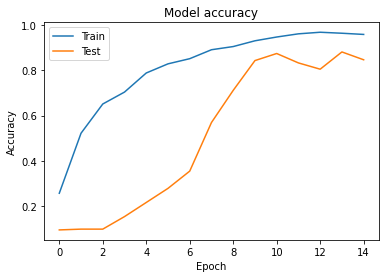

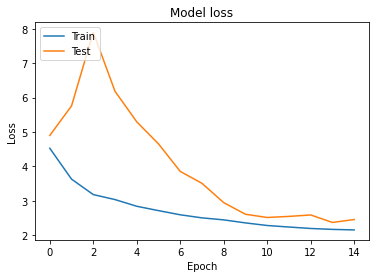

In [ ]:
history = s3d.fit(train_ds,
                  steps_per_epoch=train_steps,
                  validation_data=valid_ds,
                  validation_steps=valid_steps,
                  callbacks=callbacks,
                  epochs=num_epochs,
                  verbose=1)
plot_history(history)

In [ ]:
"""
Measure test accuracy
"""
s3d.evaluate(test_ds, steps=test_steps)
videos, labels = next(iter(test_ds.shuffle(buffer_size=200).take(1)))
y_hats = np.argmax(s3d.predict(videos), axis=1)
plot_frames(videos, labels, 8, 2, y_hats=y_hats)

10/10 [==============================] - 8s 592ms/step - loss: 2.4429 - sparse_categorical_accuracy: 0.8625
